# TODO

- documentation
    - straightness module
    - geodesic class

- this tutorial in order

- measure curvature

- compare losses
    angle vs. distance
    
- mnist shift for a classifier

In [276]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyrtools as pt
import plenoptic as po

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32
torch.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.6.0'

# Fourier magnitude demo

In [277]:
einstein = po.make_basic_stimuli(256, requires_grad=False)[-1]

n_steps = 11
video = torch.empty(n_steps, *einstein.shape)

video[0] = einstein
for shift in range(1, n_steps):
    video[shift] = torch.roll(einstein, shift, [2])

c = 64
video = video[...,c:-c, c:-c]
video = po.rescale(video, 0, 1)

imgA = video[0:1]
imgB = video[-1:]

pt.image_stats(po.to_numpy(imgA))
pt.image_stats(po.to_numpy(imgB))
print(imgA.shape)

print(video.shape)
pt.animshow(po.to_numpy(video).squeeze(), zoom=2)

Image statistics:
  Range: [0.000000, 1.000000]
  Mean: 0.469115,  Stdev: 0.165756,  Kurtosis: 3.675402
Image statistics:
  Range: [0.000000, 1.000000]
  Mean: 0.480635,  Stdev: 0.165142,  Kurtosis: 3.627025
torch.Size([1, 1, 128, 128])
torch.Size([11, 1, 128, 128])


In [5]:
def fourier(x):
    return torch.rfft(x, 2)

def amp_phase(x):
    return torch.cat(po.rectangular_to_polar( *fourier(x).unbind(-1) ), 1)

def fourier_amp(x):
    return po.rectangular_to_polar( *fourier(x).unbind(-1) )[0]

In [ ]:
metamer = po.synth.Metamer(imgA, fourier_amp)

In [ ]:
matched_image, matched_representation = metamer.synthesize()

In [ ]:
pt.imshow([imgA.squeeze(), matched_image.squeeze()]);
# m = po.to_numpy(matched_representation).squeeze()
# also show the representations

In [ ]:
moog = po.synth.Geodesic(imgA, imgB, fourier_amp, len(video), init='straight', lmbda=.1)
moog.synthesize()

video  = po.to_numpy(video).squeeze()
geodesic  = po.to_numpy(moog.geodesic).squeeze()
pixelfade = po.to_numpy(moog.pixelfade).squeeze()

In [ ]:
fig = pt.imshow([video[5], pixelfade[5], geodesic[5]],
          title=['video', 'pixelfade', 'geodesic'],
          col_wrap=3, zoom=4);

h = 98
m = 64
l = 30

# for a in fig.get_axes()[0]:
a = fig.get_axes()[0]
for line in (h, m, l):
    a.axhline(line, lw=2)


pt.imshow([video[:,l], pixelfade[:,l], geodesic[:,l]],
          title=None, col_wrap=3, zoom=2);
pt.imshow([video[:,m], pixelfade[:,m], geodesic[:,m]],
          title=None, col_wrap=3, zoom=2);
pt.imshow([video[:,h], pixelfade[:,h], geodesic[:,h]],
          title=None, col_wrap=3, zoom=2);

# LGN V1 demo

In [ ]:
# - speedup front_end -> LGN V1 -> complex

## model

In [ ]:
model = po.simul.Steerable_GainControl(imgB.shape[-2:], is_complex=True, residuals=False).eval()
# model = po.simul.Steerable_GainControl(imgB.shape[-2:], is_complex=True, n_ori=4, n_scale=5, residuals=False, front_end=True).eval()

In [ ]:
with torch.no_grad():
    yA = model(imgA)
    yB = model(imgB)
imgA.requires_grad, yA.requires_grad

In [ ]:
# %debug

In [ ]:
yA.shape, yA.numel()

In [ ]:
n_steps = len(video)
moog = po.synth.Geodesic(imgA, imgB, model, n_steps, init='straight', lmbda=.1)

print('shape trainable param', '# trainable param')
#  sum(p.numel() for p in moog.parameters())
[p.shape for p in moog.parameters() if p.requires_grad], sum(p.numel() for p in moog.parameters() if p.requires_grad)

In [ ]:
moog.synthesize()

In [ ]:
plt.semilogy(moog.loss)
plt.xlabel('iter step')
plt.ylabel('loss value')
# plt.ylim([1e-1, .5])
plt.show()

## histograms

In [ ]:
geodesic  = po.to_numpy(moog.geodesic).squeeze()
pixelfade = po.to_numpy(moog.pixelfade).squeeze()
geodesic.shape, pixelfade.shape

In [ ]:
plt.hist(video.flatten(), histtype='step', density=True, label='video')
plt.hist(pixelfade.flatten(), histtype='step', density=True, label='pixelfade')
plt.hist(geodesic.flatten(), histtype='step', density=True, label='geodesic');
plt.yscale('log')
plt.title('signal value histogram')
plt.legend(loc=1)
plt.show()

## geodesic

In [ ]:
print('geodesic')
pt.imshow(geodesic, vrange='auto1', title=None);
print('diff')
pt.imshow(geodesic - pixelfade, vrange='auto1', title=None);
print('pixelfade')
pt.imshow(pixelfade, vrange='auto1', title=None);

In [ ]:
# pt.animshow(geodesic, framerate=10, zoom=1, repeat=True)
# pt.animshow(geodesic - pixelfade, vrange='auto1')

In [ ]:
pt.animshow([geodesic, pixelfade], 
            title=['geodesic', 'pixelfade'], vrange='indep1',
            framerate=10, zoom=1, repeat=True)

## horizontal slice

In [ ]:
print('pixelfade', '\n geodesic', '\n video')
pt.imshow([pixelfade[:,64], geodesic[:,64], video[:,64]],
          title=None, col_wrap=1, zoom=4);

## Deviation from the straight line

In [ ]:
plt.plot(po.to_numpy(moog.distance_from_line(video)), 'b-o', label='video')
plt.plot(po.to_numpy(moog.distance_from_line(moog.pixelfade)), 'g-o', label='pixelfade')
plt.plot(po.to_numpy(moog.distance_from_line(moog.geodesic)), 'r-o', label='geodesic')
plt.legend(loc=1)
plt.ylabel('distance from representation line')
plt.xlabel('projection on representation line')
# plt.yscale('log')
plt.show()

In [ ]:
from IPython.display import HTML
from matplotlib import animation

fig, ax = plt.subplots()
ax.plot(po.to_numpy(moog.distance_from_line(video)), 'b-o', label='video')
ax.plot(po.to_numpy(moog.distance_from_line(moog.pixelfade)), 'g-o', label='pixelfade')
artist, = ax.plot(po.to_numpy(moog.distance_from_line(moog.geodesic)), 'r-o', label='geodesic')
plt.legend(loc=1)
plt.ylabel('distance from representation line')
plt.xlabel('projection on representation line');
# plt.yscale('log')

def animate(i):

    artist.set_data(range(11), po.to_numpy(moog.dist_from_line[i]).squeeze())
#     artist.
    return (artist,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=100, interval=20, blit=True, repeat=False)
HTML(anim.to_html5_video())

In [ ]:
plt.plot(torch.cat(moog.dist_from_line, 0))

plt.title('evolution of distance from representation line')
plt.ylabel('distance from representation line')
plt.xlabel('iteration step')
# plt.yscale('log')
plt.show()

In [ ]:
step_lengths = torch.cat(moog.step_lengths, dim=0)
# plt.plot(step_lengths[:, 0], 'r--');
plt.plot(step_lengths);
plt.axhline(po.to_numpy(moog.reference_length / (moog.n_steps - 1)), ls='--', c='k')

plt.xlabel('iteration step')
plt.ylabel('step length')
plt.title('evolution of geodesic step lengths in representation space')

plt.yscale('log')
# plt.ylim([0,2])
# plt.xlim([0,40])
plt.show()

## representation plot

In [ ]:
pt.pyrshow(moog.model(imgA, vectorize=False));

In [ ]:
pt.animshow([po.to_numpy(y).squeeze() for y in moog.model(moog.geodesic, vectorize=False).values()],
           col_wrap=4, framerate=11, repeat=True, vrange='indep1', title=None)

In [ ]:
pt.animshow([po.to_numpy(y).squeeze() for y in moog.model(moog.pixelfade, vectorize=False).values()],
           col_wrap=4, framerate=11, repeat=True, vrange='indep1', title=None)

# VGG demo

In [ ]:
# - color images, VGG

In [ ]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)

plt.imshow(input_image)

In [ ]:
# https://pytorch.org/hub/pytorch_vision_vgg/
    
"""The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]"""


# transform = transforms.ToTensor()

# transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
#                                           shuffle=True, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# dataiter = iter(trainloader)
# images, labels = dataiter.next()

# pt.imshow(images[:,0], title=[classes[l] for l in labels], zoom=8);

In [ ]:
class NthLayer(nn.Module):
    """Wrap any model to get the response of an intermediate layer"""
    def __init__(self, model, layer=None):
        """
        Parameters
        ----------
        model: PyTorch model
        layer: int
            Which model response layer to output
        """
        super().__init__()
        features = list(model.features)
        self.features = nn.ModuleList(features).eval()

        if layer is None:
            layer = len(self.features)
        self.layer = layer

    def forward(self, x):
        
        if x.shape[1] == 1:
            x = x.repeat(1,3,1,1)
            
        
        for ii, mdl in enumerate(self.features):
            x = mdl(x)
            if ii == self.layer:
                return x

models.vgg16(pretrained=True).features

In [ ]:
# different potential models of human visual perception of distortions
# pooling layers: 4, 9, 16, 23
model = NthLayer(models.vgg16(pretrained=True), layer=9)

# conditional geodesic

In [ ]:
### conditional geodesic (for many-to-one analysis transforms)
# repr_obj = self.objective_function(output)
# repr_obj.backward()
# repr_grad = self.x.grad
#
# self.optimizer.zero_grad()
# signal_obj = self.objective_function(self.x_full.view(self.n_steps, -1))
# signal_obj.backward()
# signal_grad = self.x.grad
#
# self.optimizer.zero_grad()
# self.x.grad = signal_grad - (repr_grad @ signal_grad) * repr_grad / norm(repr_grad)
###

# texture statistics demo

In [ ]:
# - spectral (broken?) -> texture_statistics (renamed), no dwonsampling, phase correlations

In [ ]:
# model = po.simul.Spectral(imgA.shape[-2:])

In [ ]:
# plt.plot(yA, yB, '.');

In [ ]:
# plt.plot(model(video));

In [ ]:
# # imageA = x[0]
# # imageB = x[-1]
path = '../data/'
nameA = 'reptil_skin'
nameB = 'metal'
imageA = plt.imread(path + nameA + '.pgm') / 255.
imageB = plt.imread(path + nameB + '.pgm') / 255.

imageA = imageA[c:-c, c:-c]
imageB = imageB[c:-c, c:-c]
pt.image_stats(imageA)
pt.image_stats(imageB)

imgSize = imageA.shape[0]
pt.imshow([imageA, (imageA + imageB)/2, imageB], vrange='indep1', zoom=2);

In [ ]:
imgA = torch.tensor(imageA, dtype=dtype).unsqueeze(0).unsqueeze(0)
imgB = torch.tensor(imageB, dtype=dtype).unsqueeze(0).unsqueeze(0)

print(imgA.shape)
from plenoptic.tools.straightness import make_straight_line
video = make_straight_line(imgA, imgB, n_steps)
print(video.shape)
pt.image_stats(po.to_numpy(video).squeeze())
pt.animshow(po.to_numpy(video).squeeze(), zoom=2)


In [ ]:
# path = '../data/'

# nameA = 'sawtooth'
# nameB = 'checkerboard'

# nameA = 'reptil_skin'
# nameB = 'metal'
# imageA = 2 * plt.imread(path + nameA + '.pgm') / 255. - 1
# imageB = 2 * plt.imread(path + nameB + '.pgm') / 255.

# imageA = pt.blurDn(imageA, 1, 'qmf9')
# imageB = pt.blurDn(imageB, 1, 'qmf9')
# imageA = po.rescale(imageA, 0, 255)
# imageB = po.rescale(imageB, 0, 255)

# (2*imgA/255 - 1).view(1, image_size, image_size)
        # rescale image to [-1,1]
        # rescale(imgA)
        # self.xA = (2*imgA/255 - 1).view(1, image_size, image_size)
        # self.xB = (2*imgB/255 - 1).view(1, image_size, image_size)

# manifold geometry

triangle sum of angles

investigating image manifold curvature by measuring angles between geodesics of a trio

parallelogram

In [ ]:
# def make_moving_edge(size=64, phases=np.linspace(-.5, 0, 11)):
#     moving_edge = []
#     for p in phases:
#         step_edge = pt.synthetic_images.square_wave(size=size, period=4*size + 1, direction=0, amplitude=1, phase=p)
#         moving_edge.append(step_edge)
#     return np.array(moving_edge)

# x = make_moving_edge()
# # plt.hist(x.flatten())

# pt.imshow(x);

# noisy optim

In [ ]:
#         if noise is not None:
#             h0 = torch.FloatTensor([.001])
#             beta = torch.FloatTensor([noise])
#             # need to adapt to y's dim
#             # sigma = torch.sum(y**2, dim=1, keepdim=True) ** .5
#             # sigma /= torch.sqrt(torch.FloatTensor([y.shape[1]]))
#             sigma = torch.sum(self.x**2, dim=(1,2,3), keepdim=True) ** .5
#             sigma /= torch.sqrt(torch.prod(torch.FloatTensor([self.image_size[1:]])))

#             grad_norms = torch.sum(self.x.grad.data ** 2, dim=(1,2,3), keepdim=True) ** .5
#             grad_norms /= torch.sqrt(torch.prod(torch.FloatTensor([self.image_size[-2:]])))
#             h = h0*i/(1+ (h0*(i-1)) )
#             gamma = sigma * torch.sqrt( (1 - (beta*h))**2 - (1-h)**2)

#             # print(h, gamma)
#             # gamma = gamma.unsqueeze(1).unsqueeze(1)
#             h = h.view(1,1,1,1)
#             self.x.data -= h*self.x.grad.data + gamma*torch.randn_like(self.x.grad.data)

#         else:

# multiscale

In [ ]:
# Haar_1d

#### multi-scale tools
# self.n_scales = int(np.log2(self.n_steps))
# self.diff = nn.Conv1d(1, 1, (2), bias=False)
# self.blur = nn.Conv1d(1, 1, (2), bias=False, stride=(2))
# self.diff.weight.requires_grad = False
# self.blur.weight.requires_grad = False
# self.diff.weight = nn.Parameter(torch.tensor([[[-1., 1.]]]))
# self.blur.weight = nn.Parameter(torch.ones_like(self.diff.weight))
# self.diff.weight.requires_grad = False
# self.blur.weight.requires_grad = False
# older
# self.diff = nn.Conv3d(1, 1, (2, 1, 1), bias=False)
# self.blur = nn.Conv3d(1, 1, (2, 1, 1), bias=False, stride=(2, 1, 1))
# self.diff.weight.requires_grad = False
# self.blur.weight.requires_grad = False
# self.diff.weight = nn.Parameter(torch.tensor([[[[[-1.]], [[1.]]]]]))
# self.blur.weight = nn.Parameter(torch.ones_like(self.diff.weight))
# self.diff.weight.requires_grad = False
# self.blur.weight.requires_grad = False
# ojective
# loss = 0
# for s in range(self.n_scales):
#     loss = loss + torch.sum(self.diff(z) ** 2)
#     z = self.blur(z)
# return loss
####

# other metrics

In [ ]:
# def metric(self, x):
#     return torch.norm(x, 1)
#     return torch.norm(x)
#     return torch.norm(x) ** 2

In [ ]:
plt.hist(y, bins=200, density=True, histtype='step');
plt.hist(x, bins=200, density=True, histtype='step');
# plt.axhline(1, ls='--')
plt.yscale('log')

In [ ]:
# use the log empirical dist as metric (with interp1d)

In [ ]:
y = po.to_numpy(moog.yA.flatten())
x = np.random.randn(moog.yA.numel())

hx, bx = np.histogram(x, 200)
hy, by = np.histogram(y, 200)
plt.plot(bx[1:], -(hx - hx.max()))
plt.plot(by[1:], -(hy - hy.max()))
plt.yscale('log')
# plt.gca().invert_yaxis()

# back and forth

In [ ]:
# forth = pt.animshow(geodesic)
# back  = pt.animshow(geodesic[::-1])

# forth
# back

# Autoregressive

## generalize geodesic to AR_loss

In [285]:
video.shape, imgA.shape

(torch.Size([11, 1, 128, 128]), torch.Size([1, 1, 128, 128]))

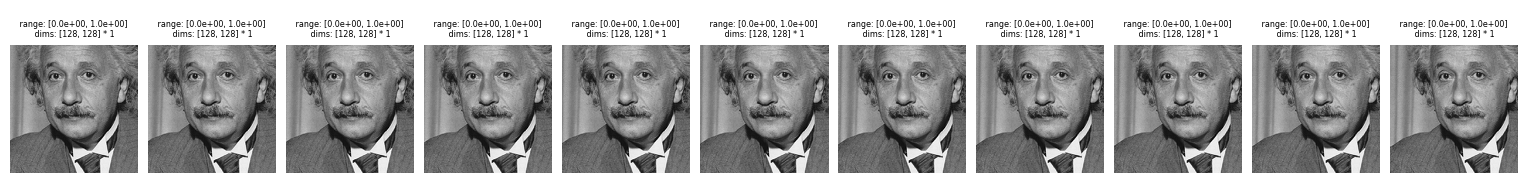

In [283]:
pt.imshow(po.to_numpy(video).squeeze());

In [297]:
sp_model = po.simul.Steerable_Pyramid_Freq(video.shape[-2:], downsample=False)
sp_model(video).shape

torch.Size([11, 22, 128, 128])

In [324]:
class AutoRegGeod(po.synth.Geodesic):
    """
    alpha: fitted on videos
    MPES: minimal prediction error sequence
    """
    def objective_function(self, y, w):
        """relative to straight interpolation
        """
        yy = torch.cat((self.yA, y, self.yB), 0).permute(1,0,2,3).unsqueeze(0)
        print(yy.shape)
        print(F.conv3d(yy, w, groups=y.shape[1]).shape)
        
        step_lengths = torch.empty(1, self.n_steps - 1)

        step_lengths[:, 0] = self.metric(self.yA - y[0])
        for i in range(1, self.n_steps-2):
            step_lengths[:, i] = self.metric(y[i] - y[i-1])
        step_lengths[:, -1] = self.metric(self.yB - y[-1])

        loss = torch.sum(step_lengths)
        self.step_lengths.append(step_lengths.detach())

        return loss / self.reference_length - 1

In [325]:
G = AutoRegGeod(imgA, imgB, sp_model)

In [330]:
w = torch.FloatTensor([-1, 1]).view(1,1,2,1,1).repeat(22,1,1,1,1)

In [331]:
G.objective_function(G.analyze(), w)

torch.Size([1, 22, 11, 128, 128])
torch.Size([1, 22, 10, 128, 128])


tensor(-4.1723e-07, grad_fn=<SubBackward0>)

In [337]:
yy = sp_model(video).permute(1,0,2,3).unsqueeze(0)

In [338]:
w.shape, yy.shape

(torch.Size([22, 1, 2, 1, 1]), torch.Size([1, 22, 11, 128, 128]))

In [340]:
z = F.conv3d(yy, w, groups=yy.shape[1])
z.shape

torch.Size([1, 22, 10, 128, 128])

Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): inf


(0.0, 0.0, 0.0, 0.0, inf)

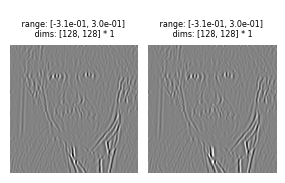

In [347]:
pt.imshow([z[0, 1, 0], -yy[0, 1, 0] + yy[0, 1, 1]]);
pt.image_compare(po.to_numpy(z[0, 1, 0]), po.to_numpy(-yy[0, 1, 0] + yy[0, 1, 1]))

In [261]:
c = 18
k = 3
conv = nn.Conv3d(c, c, kernel_size=(k,1,1), groups=c, bias=False)

In [268]:
model.conv.weight.data.shape

torch.Size([18, 1, 8, 1, 1])

In [262]:
conv(x).shape

torch.Size([2, 18, 9, 64, 64])

In [302]:
import torch.nn.functional as F

In [264]:
pred = F.conv3d(x, model.conv.weight.data, groups=c)

In [266]:
x.shape, model.conv.weight.data.shape, pred.shape

(torch.Size([2, 18, 11, 64, 64]),
 torch.Size([18, 1, 8, 1, 1]),
 torch.Size([2, 18, 4, 64, 64]))

In [14]:
a.synthesize(100)


100%|██████████| 1000/1000 [00:16<00:00, 59.38it/s, loss=1.1837e-04, gradient norm=3.7544e-02, lr=0.001][A


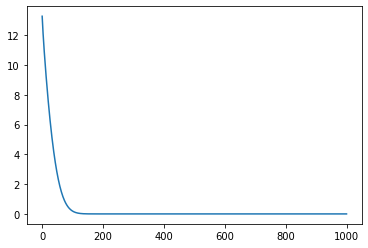

In [15]:
plt.plot(a.loss)

## LS fit of AR model on top of steerpyr

In [205]:
from torchvision import datasets, transforms

class MovingMNIST(object):
    """Data Handler that creates Bouncing MNIST dataset on the fly.

    max_displacement: field that controls speed distribution

    returns array of shape BCTHW
    """

    def __init__(self, data_root='/Users/pe/Documents/images/', train=True, seq_len=20, num_digits=2, image_size=64, digit_size=28, max_displacement=4, deterministic=True):

        self.seq_len = seq_len
        self.num_digits = num_digits
        self.image_size = image_size
        self.max_displacement = max_displacement
        self.digit_size = digit_size
        self.deterministic = deterministic
        self.seed_is_set = False # multi threaded loading?
        self.channels = 1

        # note: because embedded inlarder see of zeros, normalization at this stage would create artifacts
        # train_norm = transforms.Normalize((0.1306,), (0.3081,))
        # test_norm = transforms.Normalize((0.1325,), (0.3105,))

        self.data = datasets.MNIST(data_root,
                                   train=train,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(self.digit_size),
                                                                 transforms.ToTensor()]
                                                                )
                                   )

        self.N = len(self.data)

    def set_seed(self, seed):
        if not self.seed_is_set:
            self.seed_is_set = True
            np.random.seed(seed)

    def __len__(self):
        return self.N

    def __getitem__(self, index):
        self.set_seed(index)

        image_size = self.image_size
        digit_size = self.digit_size
        max_displacement = self.max_displacement

        x = np.zeros((self.channels,
                      self.seq_len,
                      image_size,
                      image_size),
                    dtype=np.float32)
        for n in range(self.num_digits):
            idx = np.random.randint(self.N)
            digit, _ = self.data[idx]
            # note: extra randomness to pick each of the num_digits

            sx = np.random.randint(image_size-digit_size)
            sy = np.random.randint(image_size-digit_size)
            dx = np.random.randint(-max_displacement, max_displacement+1)
            dy = np.random.randint(-max_displacement, max_displacement+1)
            for t in range(self.seq_len):
                if sy < 0:
                    sy = 0
                    if self.deterministic:
                        dy = -dy
                    else:
                        dy = np.random.randint(1, max_displacement+1)
                        dx = np.random.randint(-max_displacement, max_displacement+1)
                elif sy >= image_size-digit_size:
                    sy = image_size-digit_size-1
                    if self.deterministic:
                        dy = -dy
                    else:
                        dy = np.random.randint(-max_displacement, 0)
                        dx = np.random.randint(-max_displacement, max_displacement+1)

                if sx < 0:
                    sx = 0
                    if self.deterministic:
                        dx = -dx
                    else:
                        dx = np.random.randint(1, max_displacement+1)
                        dy = np.random.randint(-max_displacement, max_displacement+1)
                elif sx >= image_size-digit_size:
                    sx = image_size-digit_size-1
                    if self.deterministic:
                        dx = -dx
                    else:
                        dx = np.random.randint(-max_displacement, 0)
                        dy = np.random.randint(-max_displacement, max_displacement+1)

                x[0, t, sy:sy+digit_size, sx:sx+digit_size] += digit.numpy().squeeze()
                sy += dy
                sx += dx

        # impose occlusion (motion transparency), instead of superposition
        x[x>1] = 1.

        return x

from torch.utils.data import DataLoader
train_loader = DataLoader(MovingMNIST(train=True, max_displacement=3, seq_len=11, deterministic=True),
                          num_workers=0, batch_size=2, shuffle=True, drop_last=False, pin_memory=False)


In [206]:
videos = iter(train_loader).next()
print(videos.shape, train_loader.__len__())

torch.Size([2, 1, 11, 64, 64]) 30000


In [207]:
pt.animshow(po.to_numpy(videos.squeeze()), framerate=11, title=None)

In [208]:
spf = po.simul.Steerable_Pyramid_Freq(videos.shape[-2:], downsample=False)

In [218]:
B, C, T, H, W = videos.shape
vids = videos.permute(0,2,1,3,4).view(B*T, C, H, W)

torch.norm(videos - vids.view(B,T,C,H,W).permute(0,2,1,3,4))

tensor(0.)

In [225]:
rep = spf(vids)
C = rep.shape[1]
rep.shape, B,T,C,H,W

(torch.Size([22, 18, 64, 64]), 2, 11, 18, 64, 64)

In [227]:
x = rep.view(B,T,C,H,W).permute(0,2,1,3,4)
x.shape

torch.Size([2, 18, 11, 64, 64])

In [231]:
class AutoRegressive(nn.Module):
    def __init__(self, k, c):
        super().__init__()
        
        self.conv = nn.Conv3d(c, c, kernel_size=(k,1,1), groups=c, bias=False)
        self.k = k
        self.c = c

    def forward(self, x):
        assert x.shape[1] == self.c
        return x[:,:,self.k:], self.conv(x)[:,:,:-1]

In [247]:
model = AutoRegressive(k=8, c=18)
y, y_hat = model(x)
y.shape, y_hat.shape, model.conv.weight.shape

NameError: name 'ar_model' is not defined

In [248]:
spf = po.simul.Steerable_Pyramid_Freq(videos.shape[-2:], downsample=False)
ar_model = AutoRegressive(k=8, c=18)

import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=.1, momentum=0.9)

In [249]:
for i, videos in enumerate(train_loader):
    if i ==5:
        break
    B, C, T, H, W = videos.shape
    vids = videos.permute(0,2,1,3,4).view(B*T, C, H, W)
    rep = spf(vids)
    C = rep.shape[1]
    x = rep.view(B,T,C,H,W).permute(0,2,1,3,4)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    y, y_hat = ar_model(x)
    loss = torch.mean((y_hat - y)**2, dim=(2,3,4)) # [B, C]
    ave_loss = loss.mean()
    ave_loss.backward()
    optimizer.step()
    print(ave_loss.item())

0.004078675527125597
0.0037093949504196644
0.0033281692303717136
0.002315174788236618
0.0030705630779266357


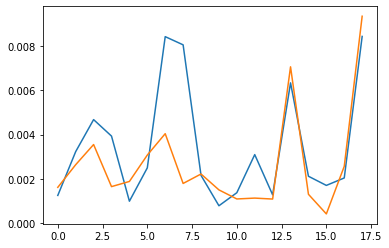

In [250]:
plt.plot(po.to_numpy(loss).T);

tensor(1.1412)

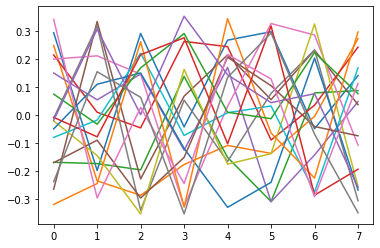

In [251]:
plt.plot(model.conv.weight.data.squeeze().T);
model.conv.weight.data.sum()

In [255]:
x.shape

torch.Size([2, 18, 11, 64, 64])

## using fitted AR in geodesic